<a href="https://colab.research.google.com/github/jellydaniellie/cs6501-project2/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install googlemaps
!pip install pytz
import json
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import folium
import googlemaps
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt

In [ ]:
# load and preprocess google timeline data
def load_timeline_data(timeline_path):
  LOCAL_TZ = pytz.timezone("America/New_York")
  with open(timeline_path, 'r', encoding='utf-8') as f:
    data = json.load(f)
  locations = []
  for entry in data:
    start_time = entry.get('startTime')
    dt_start = datetime.fromisoformat(start_time)
    dt_start = dt_start.astimezone(LOCAL_TZ)


    end_time = entry.get('endTime')
    dt_end = datetime.fromisoformat(end_time)
    dt_end = dt_end.astimezone(LOCAL_TZ)

    if entry.get('visit'):
      locs = entry['visit']['topCandidate']['placeLocation'][4:].split(",")
      lat = float(locs[0])
      lon = float(locs[1])
      locations.append({'activity_type':'visit','start_time': dt_start, 'end_time': dt_end, 'lat':lat, 'lon':lon})

    elif entry.get('activity'):
      start = entry['activity']['start'][4:].split(",")
      start_lat = float(start[0])
      start_lon = float(start[1])

      # end = entry['activity']['end'][4:].split(",")
      # end_lat = float(end[0])
      # end_lon = float(end[1])
      locations.append({'activity_type':'activity','start_time': dt_start, 'end_time': dt_end, 'lat':start_lat, 'lon': start_lon})

    elif entry.get('timelinePath'):
      item = entry['timelinePath'][0]
      duration = int(item['durationMinutesOffsetFromStartTime'])
      dt_end = dt_start + timedelta(minutes=duration)

      loc = item['point'][4:].split(',')
      lat = float(loc[0])
      lon = float(loc[1])
      locations.append({'activity_type':'path','start_time': dt_start, 'end_time': dt_end, 'lat':lat, 'lon':lon})
  df = pd.DataFrame(locations)
  return df

In [ ]:
ds_tl = "/content/drive/MyDrive/Colab Notebooks/project 2/location-history.json"
test_tl = "/content/drive/MyDrive/Colab Notebooks/project 2/testfile.json"
print(load_timeline_data(ds_tl))

   activity_type                       start_time  \
0          visit 2025-02-09 18:04:51.921000-05:00   
1       activity 2025-02-09 18:27:58.508000-05:00   
2          visit 2025-02-09 18:30:02.519000-05:00   
3       activity 2025-02-09 18:35:00.985000-05:00   
4          visit 2025-02-09 20:34:37.522000-05:00   
..           ...                              ...   
71          path        2025-03-16 07:00:00-04:00   
72          path        2025-03-25 15:00:00-04:00   
73          path        2025-03-26 09:00:00-04:00   
74          path        2025-03-26 11:00:00-04:00   
75          path        2025-03-26 13:00:00-04:00   

                           end_time        lat        lon  
0  2025-02-09 18:27:58.508000-05:00  37.278870 -76.748917  
1  2025-02-09 18:30:02.519000-05:00  37.278783 -76.748473  
2  2025-02-09 18:35:00.985000-05:00  37.272967 -76.754887  
3  2025-02-09 20:34:37.522000-05:00  37.997551 -78.336901  
4  2025-02-12 03:51:30.057000-05:00  38.097128 -78.463688  
.. 

In [ ]:
# def find_frequent_locs(df):
#   start_counts = df.groupby(['start_lat', 'start_lon']).size().reset_index(name='count')
#   end_counts = df.groupby(['end_lat', 'end_lon']).size().reset_index(name='count')
#   end_counts.rename(columns={'end_lat': 'start_lat', 'end_lon': 'start_lon'}, inplace=True)

#   # Combine start and end counts
#   all_counts = pd.concat([start_counts, end_counts])
#   location_counts = all_counts.groupby(['start_lat', 'start_lon']).sum().reset_index()

#   # Sort by most common locations
#   most_common_locations = location_counts.sort_values(by='count', ascending=False)

#   print(most_common_locations)


    activity_type        lat        lon  cluster
0           visit  37.278870 -76.748917      0.0
1           visit  37.278870 -76.748917      0.0
2           visit  37.278870 -76.748917      0.0
3        activity  37.278783 -76.748473      0.0
4           visit  37.272967 -76.754887     -1.0
..            ...        ...        ...      ...
82           path  38.034717 -78.514128     -1.0
83           path  38.044645 -78.505869     -1.0
88           path  38.019126 -78.456878     -1.0
90           path  38.037381 -78.488215     -1.0
100          path  41.885797 -72.656361     -1.0

[83 rows x 4 columns]


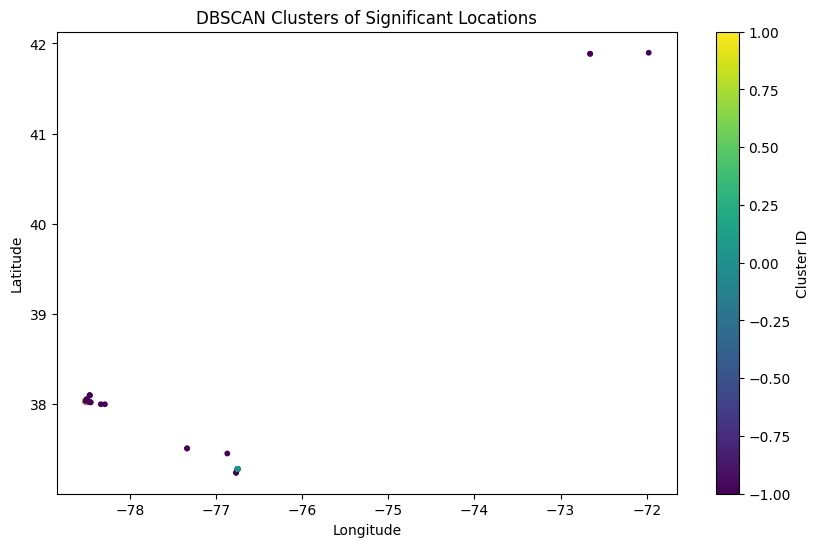

In [ ]:
def cluster_locations(df, eps=100, min_samples=5):
    """
    Uses DBSCAN to find clusters of significant locations, excluding timelinePath.

    Parameters:
    - df: DataFrame with lat, lon, activity_type columns
    - eps: Maximum distance (in meters) for clustering
    - min_samples: Minimum points to form a cluster

    Returns:
    - df with an additional 'cluster' column
    """
    # Filter only visits and activities (ignore paths)
    df_cluster = df[df['activity_type'].isin(['visit', 'activity'])].dropna(subset=['lat', 'lon'])

    # Convert lat/lon to NumPy array
    coords = df_cluster[['lat', 'lon']].to_numpy()

    # Convert eps from meters to radians (DBSCAN works in radians for Haversine distance)
    eps_rad = eps / 6371000  # Earth's radius in meters

    # Apply DBSCAN with Haversine metric
    clustering = DBSCAN(eps=eps_rad, min_samples=min_samples, metric='haversine').fit(np.radians(coords))

    # Assign cluster labels to filtered DataFrame
    df_cluster['cluster'] = clustering.labels_

    # Merge back with original DataFrame
    df = df.merge(df_cluster[['lat', 'lon', 'cluster']], on=['lat', 'lon'], how='left')

    return df

# Apply clustering
df = load_timeline_data(ds_tl)
df = cluster_locations(df)

# Display clusters
print(df[['activity_type', 'lat', 'lon', 'cluster']].dropna())

# Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(df['lon'], df['lat'], c=df['cluster'], cmap='viridis', s=10)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clusters of Significant Locations")
plt.colorbar(label="Cluster ID")
plt.show()


In [ ]:
# calling google API
def get_place_labels(df, api_key):
  # gmaps = googlemaps.Client(key=api_key)
  # unique_clusters = df[df['cluster'] != -1].groupby('cluster')[['lat', 'lon']].mean()
  # cluster_labels = {}
  # for cluster, (lat,lon) in unique_clusters.iterrows():
  #   place_result = gmaps.reverse_geocode((lat,lon), result_type=['establishment'])
  #   if place_result:
  #     cluster_labels[cluster] = place_result[0]['formatted_address']
  #   else:
  #     cluster_labels[cluster] = 'Unknown'
  # df['location_label'] = df['cluster'].map(cluster_labels)
  return df

In [ ]:
# visualization
def plot_clusters(df):
    map_center = [df['lat'].mean(), df['lon'].mean()]
    m = folium.Map(location=map_center, zoom_start=12)

    for _, row in df.iterrows():
        if row['cluster'] != -1:
            folium.Marker(
                location=[row['lat'], row['lon']],
                popup=row.get('location_label', 'Unknown Cluster'),
                icon=folium.Icon(color="blue")
            ).add_to(m)
    display(m)
    return None
plot_clusters(cluster_locations(load_timeline_data(ds_tl)))
